# Spice simulatie

<a href="./slides/Spice-simulatie.slides.html" target="_blank">![slides](./images/slides-beschikbaar-blue.svg)</a> 
<a href="../Lite/ToegepasteAnalogeElektronica/lab?path=Spice-simulatie.ipynb" target="_blank">![slides](./images/open_in-JupyterLite-blue.svg)</a>
<a href="../Deck/ToegepasteAnalogeElektronica/lab?path=Spice-simulatie.ipynb" target="_blank">![slides](./images/JupyterDeck-slides-blue.svg)</a>

In [1]:
%config InlineBackend.figure_format = 'svg'
%run cursusdef.py

In deze cursus bestuderen we elektronische circuits. Hiervoor is het belangrijk dat we deze elektronische circuits ook in detail en correct kunnen simuleren. Hiervoor gebruiken we een implementatie van SPICE. SPICE staat voor ```Simulation Program with Integrated Circuit Emphasis```. SPICE is in de jaren 1960 ontwikkeld door het [Department of Electrical Engineering and Computer Sciences in UC Berkeley, California, USA](https://eecs.berkeley.edu/) en toen reeds vrijgegeven als een eerste soort open source avant la lettre. 

Ondertussen zijn er al meer dan 100 verschillende implementaties van spice. [Hier](https://www.electronics-lab.com/downloads/circutedesignsimulation/?page=5) vind je een overzicht van een aantal implementaties. De motor van deze implementaties is nog steeds zo goed als dezelfde van deze van de originele implementaties, namelijk de modified nodale analyse ([MNA](https://en.wikipedia.org/wiki/Modified_nodal_analysis)). De verschillen tussen deze implementaties zijn in eerste instantie de user interface en de manier waarop de verschillende modellen geïmplementeerd zijn. 

In dit jupyterbook gebruik ik [PySpice](https://pyspice.fabrice-salvaire.fr/releases/v1.5/). Dit is een python interface naar [ngspice](https://ngspice.sourceforge.io/). Als je [conda](https://docs.conda.io/en/latest/miniconda.html) en [git](https://git-scm.com/) geïnstalleerd hebt en de github repository van [dit boek](https://github.com/jangenoe/InteractieveCursus) lokaal gecloned hebt, kan je de volledige PySpice omgeving die in dit boek gebruikt wordt installeren door de volgende commandos uit te voeren in de directory van deze repository:

```
git clone https://github.com/jangenoe/InteractieveCursus
cd InteractieveCursus
conda env update -f ./binder/environment.yml
conda activate KULeuven
ipython kernel install --user --name=KULeuven
pyspice-post-installation --install-ngspice-dll
```

Vervolgens kan je aan de hand van het commando ```jupyter lab``` de verschillende notebooks openen aanpassen en simuleren.

Om aan te geven hoe we gebruik maken van spice voor de circuit simulatie, kijken we naar een voorbeeld van een verschilversterker op IC. Het basisschema van deze versterker is aangegeven in {numref}`spicefig1`. Het eerste wat we moeten doen in dit circuit is de verschillende knopen een nummer (of een naam) te geven. Het resultaat waarbij elke knoop een naam gekregen heeft zien we in {numref}`spicefig1b`.

######  Overzicht
 


###### Basisschema van de verschilversterker

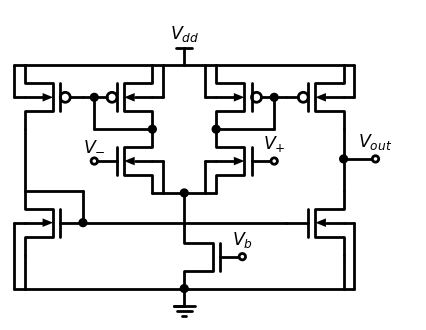

In [53]:
d = schem.Drawing()
T1 = d.add(e.NFET)
d.add(e.DOT)
d.add(e.GND, xy=T1.source)
d.add(e.LINE, xy=T1.drain, d='up', l=0.75)
central=d.add(e.DOT)

d.add(e.LINE, xy=central.start, d='left', l=0.75)
T2 = d.add(e.NFET,bulk=True)
d.add(e.DOT)
T4 = d.add(e.PFET,bulk=True)
d.add(e.LINE, xy=T4.source, d='left', tox=T4.gate)
d.add(e.LINE,  d='up', toy=T4.gate)
d.add(e.DOT)
d.add(e.LINE, xy=T4.drain, d='right', l=0.75)
vdd=d.add(e.VDD, label='$V_{dd}$')
d.add(e.LINE, d='right', l=0.75)
T5 = d.add(e.PFET,bulk=True, d='right')
d.add(e.DOT)
d.add(e.LINE, d='right', tox=T5.gate)
d.add(e.LINE,  d='up', toy=T5.gate)
d.add(e.DOT)
T3 = d.add(e.NFET,bulk=True, xy=T5.drain,d='right')
d.add(e.LINE, d='left', tox=central.start)

d.add(e.LINE, xy=T4.drain, d='left', l=3)
T6 = d.add(e.PFET,bulk=True, d='right')
d.add(e.LINE, d='right',xy=T6.gate, tox=T4.gate)
d.add(e.LINE,xy=T6.drain, d='down', l=1.45)
T7 = d.add(e.NFET,bulk=True, d='right')
d.add(e.LINE, d='down', toy=T1.source)
d.add(e.LINE, d='right', tox=T1.source)

d.add(e.LINE, d='right', l=3.75)
d.add(e.LINE, d='up', toy=T7.source)
T8 = d.add(e.NFET,bulk=True, d='left')
d.add(e.LINE, d='up', l=0.75)
out=d.add(e.DOT)
d.add(e.LINE, d='up', l=0.7)
T9 = d.add(e.PFET,bulk=True, d='left')
d.add(e.LINE,xy=T9.gate, d='left', tox=T5.gate)
d.add(e.LINE,xy=T9.drain, d='up', toy=vdd.start)
d.add(e.LINE, d='left', tox=T5.source)

d.add(e.DOT,xy=T7.gate)
d.add(e.LINE, d='up', toy=T7.source)
d.add(e.LINE, d='left', tox=T7.source)
d.add(e.LINE, d='right',xy=T7.gate, tox=T8.gate)

# all bulk connections

d.add(e.LINE, xy=T2.bulk, d='right', l=0.25)
d.add(e.LINE, toy=central.start, d='down')
d.add(e.LINE, xy=T3.bulk, d='left', l=0.25)
d.add(e.LINE, toy=central.start, d='down')
d.add(e.LINE, xy=T4.bulk, d='right', l=0.25)
d.add(e.LINE, toy=vdd.start, d='up')
d.add(e.LINE, xy=T5.bulk, d='left', l=0.25)
d.add(e.LINE, toy=vdd.start, d='up')

d.add(e.LINE, xy=T8.bulk, d='right', l=0.25)
d.add(e.LINE, toy=T1.source, d='down')
d.add(e.LINE, tox=T8.source, d='left')
d.add(e.LINE, xy=T7.bulk, d='left', l=0.25)
d.add(e.LINE, toy=T1.source, d='down')
d.add(e.LINE, tox=T7.source, d='right')
d.add(e.LINE, xy=T9.bulk, d='right', l=0.25)
d.add(e.LINE, toy=vdd.start, d='up')
d.add(e.LINE, tox=T9.source, d='left')
d.add(e.LINE, xy=T6.bulk, d='left', l=0.25)
d.add(e.LINE, toy=vdd.start, d='up')
d.add(e.LINE, tox=T6.source, d='right')
# labels

d.add(e.LINE, d='right',xy=out.start,l=0.75)
d.add(e.DOT_OPEN, label='$V_{out}$')
d.add(e.DOT_OPEN, xy=T1.gate, label='$V_{b}$')
d.add(e.DOT_OPEN, xy=T3.gate, label='$V_{+}$')
d.add(e.DOT_OPEN, xy=T2.gate, label='$V_{-}$')

d.draw()

###### Basisschema van de verschilversterker

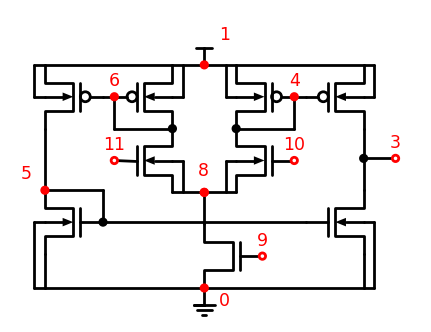

In [52]:
d = schem.Drawing()
T1 = d.add(e.NFET)
grond=d.add(e.DOT,color='red')
grond.add_label('0',  loc='center', ofst=[0.6,-.5], align=('right','bottom'))
d.add(e.GND, xy=T1.source)
d.add(e.LINE, xy=T1.drain, d='up', l=0.75)
central=d.add(e.DOT,color='red')
central.add_label('8',  loc='center', ofst=[0.1,.3], align=('right','bottom'))

d.add(e.DOT,color='red')
d.add(e.LINE, xy=central.start, d='left', l=0.75)
T2 = d.add(e.NFET,bulk=True)
d.add(e.DOT)
T4 = d.add(e.PFET,bulk=True)
d.add(e.LINE, xy=T4.source, d='left', tox=T4.gate)
d.add(e.LINE,  d='up', toy=T4.gate)
d.add(e.DOT,color='red', label='6')
d.add(e.LINE, xy=T4.drain, d='right', l=0.75)
d.add(e.DOT,color='red')
vdd=d.add(e.VDD)
vdd.add_label('1',color='red',  loc='center', ofst=[0.6,.5], align=('right','bottom'))

d.add(e.LINE, d='right', l=0.75)
T5 = d.add(e.PFET,bulk=True, d='right')
d.add(e.DOT)
d.add(e.LINE, d='right', tox=T5.gate)
d.add(e.LINE,  d='up', toy=T5.gate)
d.add(e.DOT,color='red', label='4')
T3 = d.add(e.NFET,bulk=True, xy=T5.drain,d='right')
d.add(e.LINE, d='left', tox=central.start)

d.add(e.LINE, xy=T4.drain, d='left', l=3)
T6 = d.add(e.PFET,bulk=True, d='right')
d.add(e.LINE, d='right',xy=T6.gate, tox=T4.gate)
d.add(e.LINE,xy=T6.drain, d='down', l=1.45)
L5=d.add(e.DOT,color='red')
L5.add_label('5',color='red',  loc='center', ofst=[-0.3,.2], align=('right','bottom'))
T7 = d.add(e.NFET,bulk=True, d='right')
d.add(e.LINE, d='down', toy=T1.source)
d.add(e.LINE, d='right', tox=T1.source)

d.add(e.LINE, d='right', l=3.75)
d.add(e.LINE, d='up', toy=T7.source)
T8 = d.add(e.NFET,bulk=True, d='left')
d.add(e.LINE, d='up', l=0.75)
out=d.add(e.DOT)
d.add(e.LINE, d='up', l=0.7)
T9 = d.add(e.PFET,bulk=True, d='left')
d.add(e.LINE,xy=T9.gate, d='left', tox=T5.gate)
d.add(e.LINE,xy=T9.drain, d='up', toy=vdd.start)
d.add(e.LINE, d='left', tox=T5.source)

d.add(e.DOT,xy=T7.gate)
d.add(e.LINE, d='up', toy=T7.source)
d.add(e.LINE, d='left', tox=T7.source)
d.add(e.LINE, d='right',xy=T7.gate, tox=T8.gate)

# all bulk connections

d.add(e.LINE, xy=T2.bulk, d='right', l=0.25)
d.add(e.LINE, toy=central.start, d='down')
d.add(e.LINE, xy=T3.bulk, d='left', l=0.25)
d.add(e.LINE, toy=central.start, d='down')
d.add(e.LINE, xy=T4.bulk, d='right', l=0.25)
d.add(e.LINE, toy=vdd.start, d='up')
d.add(e.LINE, xy=T5.bulk, d='left', l=0.25)
d.add(e.LINE, toy=vdd.start, d='up')

d.add(e.LINE, xy=T8.bulk, d='right', l=0.25)
d.add(e.LINE, toy=T1.source, d='down')
d.add(e.LINE, tox=T8.source, d='left')
d.add(e.LINE, xy=T7.bulk, d='left', l=0.25)
d.add(e.LINE, toy=T1.source, d='down')
d.add(e.LINE, tox=T7.source, d='right')
d.add(e.LINE, xy=T9.bulk, d='right', l=0.25)
d.add(e.LINE, toy=vdd.start, d='up')
d.add(e.LINE, tox=T9.source, d='left')
d.add(e.LINE, xy=T6.bulk, d='left', l=0.25)
d.add(e.LINE, toy=vdd.start, d='up')
d.add(e.LINE, tox=T6.source, d='right')
# labels

d.add(e.LINE, d='right',xy=out.start,l=0.75)
d.add(e.DOT_OPEN, label='3',color='red')
d.add(e.DOT_OPEN, xy=T1.gate, label='9',color='red')
d.add(e.DOT_OPEN, xy=T3.gate, label='10',color='red')
d.add(e.DOT_OPEN, xy=T2.gate, label='11',color='red')

d.draw()

De overeenkomende SPICE code voor dit circuit zie je in {numref}`spiceverschilversterker1`. Het eerste deel van deel beschrijving beschrijft de externe aangelegde spanningsbronnen. De naam van elke spanningsbron in SPICE begint met een V. We hebben de voedingsspanning (VDD) van 5 Volt tussen knoop 1 en knoop 0, de spanningsbronnen aan de positieve (10) en de negatieve (11) ingangsklem en tenslotte een biasspanning (VB) aan klem 9.

###### Spice beschrijving

```{literalinclude} ./simul/verschilversterker.sp
:language: spice
:name: spiceverschilversterker1
:caption: basiscircuit van de verschilversterker
```

In [11]:
spicelisting('simul/verschilversterker.sp')

* CIRCUIT Spice file van een verschilversterker
VDD    1 0 DC=5.0
VPLUS 10 0 DC=2.5
VMIN  11 0 SIN(2.5 50U 1E6) DC=2.5
VB    9 0 DC=1.5
C3     3 0   5.914fF
C4     4 0  14.737fF
C5     5 0  10.124fF
C6     6 0  14.434fF
C8     8 0   7.919fF
C9     9 0  15.257fF
C10   10 0 1.872fF
C11   11 0 1.688fF
C25    1 5  1fF
MN1 3 5 0 0  NMOS w=1.50u L=0.50u
MN2 0 5 5 0  NMOS w=1.50u L=0.50u
MN3 8 10 4 0 NMOS w=1.50u L=0.50U
MN4 0 9 8 0  NMOS w=4.50u L=0.50U
MN5 6 11 8 0 NMOS w=1.50u L=0.50U
MP1 1 4 3 1  PMOS w=3.50u L=0.50U
MP2 4 4 1 1  PMOS w=3.50u L=0.50U
MP3 1 6 5 1  PMOS w=3.50u L=0.50U
MP4 6 6 1 1  PMOS w=3.50u L=0.50U
.MODEL NMOS NMOS(LEVEL=1 VTO=0.50 KP=90.000E-6 LAMBDA=0.001)
.MODEL PMOS PMOS(LEVEL=1 VTO=-0.45 KP=55.000E-6 LAMBDA=0.001)

Vervolgens vinden we in de SPICE listing de capaciteiten (C) van alle knopen ten opzichte van de grondknoop (0) terug. 
De waarde van deze condensatoren is bekomen nadat de volledige lay-out van het chipontwerp is getekend. Daarna is er door een extractfunctie de overlap van de metaisatie van elk van deze knopen met het grondvlak bepaald, en op basis hiervan is de condensatorwaarde bepaald.
We vinden ook een parasitaire condensator terug ten opzichte van de voeding, i.e. C25 die staat tussen knoop 5 en de voeding.
Eigenlijk zijn deze condensatorwaardes voor een eerste simulatie van de versterking niet belangrijk. Deze waardes worden enkel belangrijk als je een exacte waarde wil uitrekenen tijdens een simulatie bij hogere frequentie.

```{exercise} Begrijp de parasitaire capaciteiten van dit ontwerp
:class: dropdown
In de spice code {numref}`spiceverschilversterker1` werden de parasitaire capaciteiten ge-extraheerd op basis van een werkelijke lay-out van het circuit. Voeg alle capaciteiten toe op het schema van {numref}`spicefig1b`
```

Vervolgens hebben we de nMOS transistors van dit circuit. Deze zijn:

###### nMOS transistors

In [13]:
spicelisting('simul/verschilversterker.sp',firstline=14,lastline=19)

MN1 3 5 0 0  NMOS w=1.50u L=0.50u
MN2 0 5 5 0  NMOS w=1.50u L=0.50u
MN3 8 10 4 0 NMOS w=1.50u L=0.50U
MN4 0 9 8 0  NMOS w=4.50u L=0.50U
MN5 6 11 8 0 NMOS w=1.50u L=0.50U

```{literalinclude} ./simul/verschilversterker.sp
:language: spice
:lines: 15-19
:name: spiceverschilversterker2
:caption: nMOS transistors van de verschilversterker
```

We kunnen deze nMOS transistors op het schema lokaliseren (zie {numref}`spicefig1c`).

###### nMOS transistors van de verschilversterker

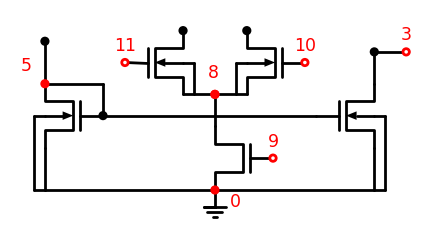

In [39]:
d = schem.Drawing()
T1 = d.add(e.NFET)
grond=d.add(e.DOT,color='red')
grond.add_label('0',  loc='center', ofst=[0.6,-.5], align=('right','bottom'))
d.add(e.GND, xy=T1.source)
d.add(e.LINE, xy=T1.drain, d='up', l=0.75)
central=d.add(e.DOT,color='red')
central.add_label('8',  loc='center', ofst=[0.1,.3], align=('right','bottom'))

d.add(e.DOT,color='red')
d.add(e.LINE, xy=central.start, d='left', l=0.75)
T2 = d.add(e.NFET,bulk=True)
d.add(e.DOT)
d.add(e.DOT, xy=[T2.source.x+1.5,T2.source.y])
T3 = d.add(e.NFET,bulk=True,d='right')
d.add(e.LINE, d='left', tox=central.start)
d.add(e.DOT,xy=[-4,2])
d.add(e.LINE, d='down', l=1)
L5=d.add(e.DOT,color='red')
L5.add_label('5',color='red',  loc='center', ofst=[-0.3,.2], align=('right','bottom'))
T7 = d.add(e.NFET,bulk=True, d='right')
d.add(e.LINE, d='down', toy=T1.source)
d.add(e.LINE, d='right', tox=T1.source)

d.add(e.LINE, d='right', l=3.75)
d.add(e.LINE, d='up', toy=T7.source)
T8 = d.add(e.NFET,bulk=True, d='left')
d.add(e.LINE, d='up', l=0.75)
out=d.add(e.DOT)
d.add(e.DOT,xy=T7.gate)
d.add(e.LINE, d='up', toy=T7.source)
d.add(e.LINE, d='left', tox=T7.source)
d.add(e.LINE, d='right',xy=T7.gate, tox=T8.gate)

# all bulk connections

d.add(e.LINE, xy=T2.bulk, d='right', l=0.25)
d.add(e.LINE, toy=central.start, d='down')
d.add(e.LINE, xy=T3.bulk, d='left', l=0.25)
d.add(e.LINE, toy=central.start, d='down')

d.add(e.LINE, xy=T8.bulk, d='right', l=0.25)
d.add(e.LINE, toy=T1.source, d='down')
d.add(e.LINE, tox=T8.source, d='left')
d.add(e.LINE, xy=T7.bulk, d='left', l=0.25)
d.add(e.LINE, toy=T1.source, d='down')
d.add(e.LINE, tox=T7.source, d='right')
# labels

d.add(e.LINE, d='right',xy=out.start,l=0.75)
d.add(e.DOT_OPEN, label='3',color='red')
d.add(e.DOT_OPEN, xy=T1.gate, label='9',color='red')
d.add(e.DOT_OPEN, xy=T3.gate, label='10',color='red')
d.add(e.DOT_OPEN, xy=T2.gate, label='11',color='red')

d.draw()

Daarna volgen de pMOS transistors van dit circuit. Deze zijn:

###### Eenvoudige transistormodellen

In [15]:
spicelisting('simul/verschilversterker.sp',firstline=19,lastline=23)

.MODEL NMOS NMOS(LEVEL=1 VTO=0.50 KP=90.000E-6 LAMBDA=0.001)
.MODEL PMOS PMOS(LEVEL=1 VTO=-0.45 KP=55.000E-6 LAMBDA=0.001)

```{literalinclude} ./simul/verschilversterker.sp
:language: spice
:lines: 20-23
:name: spiceverschilversterker3
:caption: pMOS transistors van de verschilversterker
```

Ook deze transistor kunnen we op het schema lokaliseren (zie {numref}`spicefig1d`). we herkennen hierin 2 stroomspiegels die de stromen uit de knopen 6 en 4 respectievelijk omzetten in stromen uit de knopen 5 en 3.

###### pMOS transistors van de verschilversterker

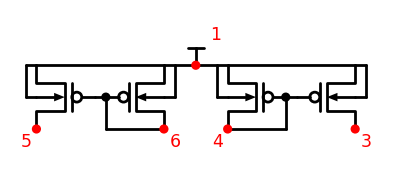

In [27]:
d = schem.Drawing()
L6=d.add(e.DOT,color='red')
T4 = d.add(e.PFET,bulk=True, d='left')
d.add(e.LINE, xy=T4.source, d='left', tox=T4.gate)
d.add(e.LINE,  d='up', toy=T4.gate)
d.add(e.DOT)
L6.add_label('6',color='red',  loc='center', ofst=[0.4,-.5], align=('right','bottom'))

d.add(e.LINE, xy=T4.drain, d='right', l=0.75)
d.add(e.DOT,color='red')
vdd=d.add(e.VDD)
vdd.add_label('1',color='red',  loc='center', ofst=[0.6,.5], align=('right','bottom'))

d.add(e.LINE, d='right',  l=0.75)
T5 = d.add(e.PFET,bulk=True, d='right')
L4=d.add(e.DOT,color='red')
L4.add_label('4',color='red',  loc='center', ofst=[-0.1,-.5], align=('right','bottom'))
d.add(e.LINE, d='right', tox=T5.gate)
d.add(e.LINE,  d='up', toy=T5.gate)
d.add(e.DOT)

d.add(e.LINE, xy=T4.drain, d='left', l=3)
T6 = d.add(e.PFET,bulk=True, d='right')
d.add(e.LINE, d='right',xy=T6.gate, tox=T4.gate)
L5=d.add(e.DOT,xy=T6.drain,color='red')
L5.add_label('5',color='red',  loc='center', ofst=[-0.1,-.5], align=('right','bottom'))

L3=d.add(e.DOT,color='red',xy=[T5.drain.x+3,T5.drain.y])
L3.add_label('3',color='red',  loc='center', ofst=[0.4,-.5], align=('right','bottom'))
T9 = d.add(e.PFET,bulk=True, d='left')
d.add(e.LINE,xy=T9.gate, d='left', tox=T5.gate)
d.add(e.LINE,xy=T9.drain, d='up', toy=vdd.start)
d.add(e.LINE, d='left', tox=T5.source)


# all bulk connections

d.add(e.LINE, xy=T4.bulk, d='right', l=0.25)
d.add(e.LINE, toy=vdd.start, d='up')
d.add(e.LINE, xy=T5.bulk, d='left', l=0.25)
d.add(e.LINE, toy=vdd.start, d='up')

d.add(e.LINE, xy=T9.bulk, d='right', l=0.25)
d.add(e.LINE, toy=vdd.start, d='up')
d.add(e.LINE, tox=T9.source, d='left')
d.add(e.LINE, xy=T6.bulk, d='left', l=0.25)
d.add(e.LINE, toy=vdd.start, d='up')
d.add(e.LINE, tox=T6.source, d='right')

d.draw()

Tenslotte hebben we ook de transistormodellen nodig van de `NMOS` en de `PMOS`. deze kan je zien in de model kaarten gegeven in {numref}`spiceverschilversterker4`

###### Eenvoudige transistormodellen

In [15]:
spicelisting('simul/verschilversterker.sp',firstline=23,lastline=25)

.MODEL NMOS NMOS(LEVEL=1 VTO=0.50 KP=90.000E-6 LAMBDA=0.001)
.MODEL PMOS PMOS(LEVEL=1 VTO=-0.45 KP=55.000E-6 LAMBDA=0.001)

```{literalinclude} ./simul/verschilversterker.sp
:language: spice
:name: spiceverschilversterker4
:lines: 24-25
:caption: Eenvoudige transistormodellen
```

Wanneer we nu een simulatie uitvoeren met een signaal van 50 $\mu V$ aan de ingangsklem 11, krijgen we een signaal van meer dan 40 $mV$ aan de uitgangsklem 3 (zie {numref}`spicefig5`. Dit geeft dus een versterking van meer dan 800.

###### Simulatie

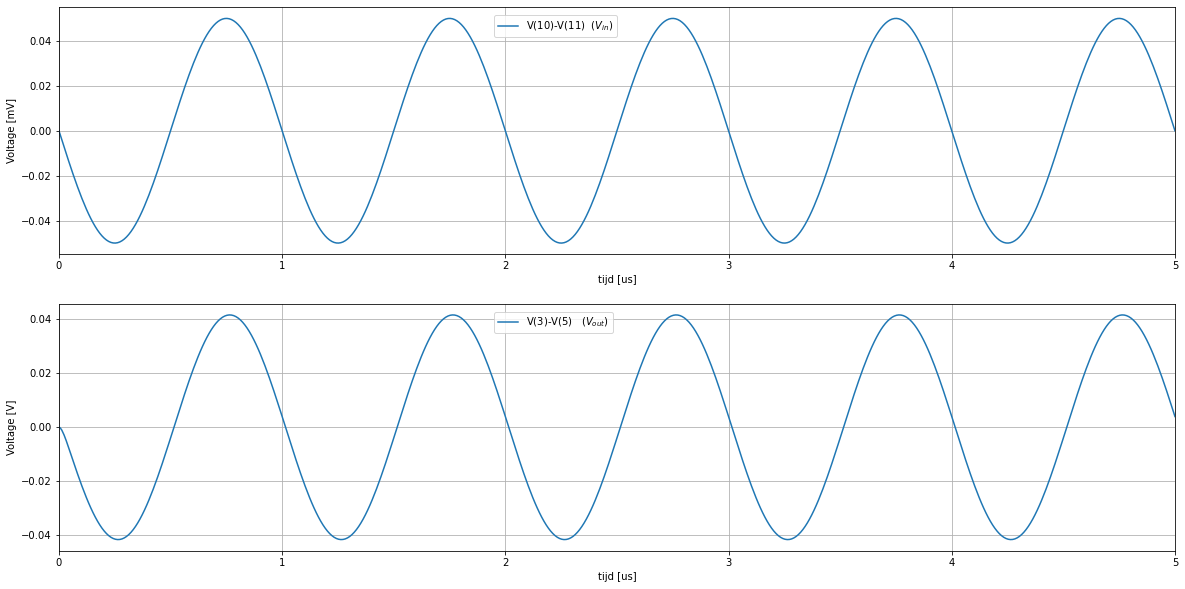

In [14]:
circuit=SpiceParser(path='simul/verschilversterker.sp').build_circuit()  
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=1e-8, end_time=5e-6)
figure, ax = plt.subplots(2,1,figsize=(20, 10))
ax[0].plot(analysis.time*1e6,(analysis.nodes['10']-analysis.nodes['11'])*1000,label='V(10)-V(11)  ($V_{in}$)')
ax[1].plot(analysis.time*1e6,analysis.nodes['3']-analysis.nodes['5'],label='V(3)-V(5)   ($V_{out}$)' )
ax[0].grid()
ax[0].legend( loc=(0.39,.88))
ax[0].set_xlabel('tijd [us]')
ax[0].set_xlim(0,5e-6*1e6)
ax[0].set_ylabel('Voltage [mV]')
ax[1].grid()
ax[1].legend( loc=(0.39,.88))
ax[1].set_xlabel('tijd [us]')
ax[1].set_xlim(0,5e-6*1e6)
ax[1].set_ylabel('Voltage [V]')
plt.show()